In [1]:
import numpy as np
from scipy import linalg
from QAOA_ansatz import create_hhl_circ, create_QAOA_ansatz
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, assemble
from qiskit.providers.aer import Aer
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

import json
import os
from math import pi
from qiskit.circuit.library.data_preparation.state_preparation import StatePreparation
from qiskit.quantum_info import Statevector
import cmath
import math

from qiskit.opflow import PauliTrotterEvolution
from qiskit.opflow import I, X, Y, Z
from taylor_precomputation import construct_asin_x_inv_circuit, construct_exp_k_abs_cos_circuit
from qiskit.circuit import qpy_serialization


In [2]:
def disp_subsyst_statevector(sv,target_qubits):
    sv_list=get_subsyt_statevectors(sv, target_qubits)
    n=int(np.log2(len(sv)))
    no_change=True
    while no_change:
        no_el=len(sv_list)
        for i in range(no_el):
            i=no_el-1-i
            sv=sv_list[i]
            if sv[2]<0.003:
                sv_list.pop(i)
                no_change=False
                continue
            for j in range(i):
                if np.allclose(sv_list[j][1],sv[1]):
                    sv_list[j][0]+=sv[0]
                    sv_list[j][0]=list(set(sv_list[j][0]))
                    sv_list[j][2]+=sv[2]
                    sv_list.pop(i)
                    no_change=False
                    break
    sv_list.sort(key=lambda sv:sv[2])
    for sv in sv_list:
        print("When remaining qubits are in states", ",".join(["|"+(str(bin(ind))[2:]).zfill(n-len(target_qubits))+">" for ind in sv[0]]), " (probability=",sv[2],"),")
        print("the statevector of qubits", ",".join([str(q) for q in target_qubits]), "is")
        print(np.around(sv[1],3))
            
    
def get_subsyt_statevectors(sv, target_qubits):
    # sv=list(np.around(np.asarray(sv),3))
    sv=np.asarray(sv)
    n=int(np.log2(len(sv)))
    remaining_qubits=[i for i in range(n) if i not in target_qubits]
    sv_list=[]
    for i in range(2**len(remaining_qubits)):
        sv_el=[]
        active_remaining_qubits=[int(c) for c in str(bin(i))[2:][::-1]]
        index_=sum([on*2**q_num for on,q_num in zip(active_remaining_qubits,remaining_qubits)])
        for j in range(2**len(target_qubits)):
            active_target_qubits=[int(c) for c in str(bin(j))[2:][::-1]]
            index=index_+sum([on*2**q_num for on,q_num in zip(active_target_qubits,target_qubits)])
            sv_el+=[sv[index]]
        sv_el_norm=(sum([np.abs(el)**2 for el in sv_el]))**0.5
        sv_el=np.array(sv_el)
        first_el_phase=cmath.phase(sv_el[0])
        sv_el=sv_el*cmath.exp(-first_el_phase*1j)
        if sv_el_norm:
            sv_el=sv_el/sv_el_norm
        sv_list+=[[[i],sv_el,sv_el_norm**2]]

    return sv_list


In [3]:
def eigenvalue_est_A(A):
    eig_max_upp_bound=max([A[i][i]+abs(sum([A[i][j]*int(j!=i) for j in range(len(A[0]))])) for i in range(len(A[0]))])
    t=np.array([int(i==0) for i in range(len(A[0]))])
    # prev_eig=0
    eig=0
    while True:
        t = (A - eig_max_upp_bound*np.eye(len(A[0]))) @ t
        if abs(linalg.norm(t)-eig)<0.0001:
            # print(t/linalg.norm(t))
            break
        eig=linalg.norm(t)
        t=t/eig
    min_eig=-eig+eig_max_upp_bound
    return (min_eig, eig_max_upp_bound)

In [4]:
real_powers=[0.6 , -0.8] #[1,1,-4]
B=[[1 , -0.2] , [-0.2 , 1.0]] #[[20,0,-10],[0,20,-10],[-10,-10,30]]
min_eigval, max_eigval= [0.8 , 1.2] #eigenvalue_est_A(B)
#min_eigval*=0.9
gen_nodes=QuantumRegister(len(real_powers) , name="gen_nodes")
tot_nodes=QuantumRegister(int(np.ceil(np.log2(len(real_powers)))), name="tot_nodes")
state_prep_anc=QuantumRegister(1, name="state_prep_anc")
hhl_phase_reg=QuantumRegister(2, name="hhl_phase_reg")
hhl_anc=QuantumRegister(1, name="hhl_anc")
num_time_slices=3

In [5]:
#circ=QuantumCircuit(gen_nodes,tot_nodes,state_prep_anc,hhl_phase_reg,hhl_anc)

#def create_hhl_circ(real_powers,B,max_eigval,min_eigval,gen_nodes,tot_nodes,state_prep_anc,hhl_phase_reg,hhl_anc,num_time_slices=3):

"""
Creates a quantum circuit to perform HHL.
real_powers (list | numpy.array): Contains real powers of all nodes
B (list of lists | numpy.array with dimension 2): Susceptance matrix of all nodes
max_eigval (float): Upper bound for maximum eigenvalue of B
min_eigval (float): Lower bound for minimum eigenvalue of B
gen_nodes (QuantumRegister): Contains qubits each representing a generator node
tot_nodes (QuantumRegister): Contains qubits where each basis state represents a node
stat_prep_anc (QuantumRegister): Contains one qubit used to prepare the initial state
hhl_phase_reg (QuantumRegister): Register of qubits for storing eigenvalues during HHL
hhl_anc (QuantumRegister): Contains one qubit used for eigenvalue inversion during HHL
num_time_slices (int): Number of time slices used for trotterized hamiltonian evolution
Returns:
hhl_circ (QuantumCircuit): Quantum circuit that performs HHL
"""
print()

In [6]:
hhl_circ=QuantumCircuit(gen_nodes,tot_nodes,state_prep_anc,hhl_phase_reg,hhl_anc, name="hhl_circ")

# If the circuit is already stored in a file, then just read the file

with open("circuit_ID.json") as f:
    # This json file contains descriptions of circuits as keys and their
    # respective filenames as values
    circuit_IDs=json.load(f)

# Circuit qpy files are stored in ../circuits
current_dir=os.getcwd()
circuits_dir=os.path.join(current_dir, "circuits")

# Key describing the circuit used in json file to identify circuits
circuit_key="HHL_"+str(real_powers)+"_"+str(B)+"_"+str(max_eigval)+"_"+str(min_eigval)+\
            "_"+str(len(hhl_phase_reg))+"_"+str(num_time_slices)

print("Check if HHL circuit already exists")

circuit_ID=False

try:
    circuit_ID=circuit_IDs[circuit_key]
    print("Circuit exists. Circuit ID:", circuit_ID)
except Exception as e:
    print(e)

if circuit_ID:
    # Read the file to get the circuit and return it
    with open(os.path.join(circuits_dir,circuit_ID+'.qpy'), 'rb') as fd:
        circuit = qpy_serialization.load(fd)[0]
        hhl_circ.compose(circuit, inplace=True)
    #return hhl_circ


Check if HHL circuit already exists
'HHL_[0.6, -0.8]_[[1, -0.2], [-0.2, 1.0]]_1.2_0.8_2_3'


In [7]:

print("real_powers before normailzation")
print(real_powers)

print("Constructing HHL Circuit")

# Rescaling and resizing

# Normalize the real_powers vector. This is the state we often call |b> when explaining HHL
real_powers_norm=np.linalg.norm(np.array(real_powers))
real_powers=np.array(real_powers)/real_powers_norm

print("real_powersafter normalization:")
print(real_powers_norm , real_powers)

real_powers before normailzation
[0.6, -0.8]
Constructing HHL Circuit
real_powersafter normalization:
1.0 [ 0.6 -0.8]


In [8]:

# Number of extra dimensions we need to make our vector length a power of 2
extra_dim=2**len(tot_nodes)-len(real_powers)

# Make real_powers look more like a statevector
real_powers=np.concatenate((real_powers, np.array([0 for _ in range(extra_dim)])))
B=np.array(B)
print("Initial B:\n", B)
print(real_powers, extra_dim)

Initial B:
 [[ 1.  -0.2]
 [-0.2  1. ]]
[ 0.6 -0.8] 0


In [9]:

# Scale B such that the eigenvalues are scaled in such a way that the largest bitstring (111...111)
# in the phase register represents the max of 1/C and max_eigval
B=B*2*pi/max_eigval

B=np.concatenate((B, np.zeros((extra_dim, len(list(B))))))
B=np.concatenate((B, np.zeros((len(list(B)), extra_dim))), axis=1)
for i in range(1,extra_dim+1):
    B[-i][-i]=1

print("Final B:\n", B)

# State prep

Final B:
 [[ 5.23598776 -1.04719755]
 [-1.04719755  5.23598776]]


In [10]:
for i in range(len(gen_nodes)):
    # Take the i-th entry in tot_nodes' statevector to the last position in the statevector
    for j in range(len(tot_nodes)):
        if i%(2**(j+1))<2**j:
            print(i,j)

0 0


In [11]:
real_powers

array([ 0.6, -0.8])

In [12]:
hhl_circ.append(StatePreparation(real_powers), tot_nodes)


In [13]:
# st1 = Statevector.from_instruction(hhl_circ)
# print("ST1:")
# disp_subsyst_statevector(st1,[2,3])

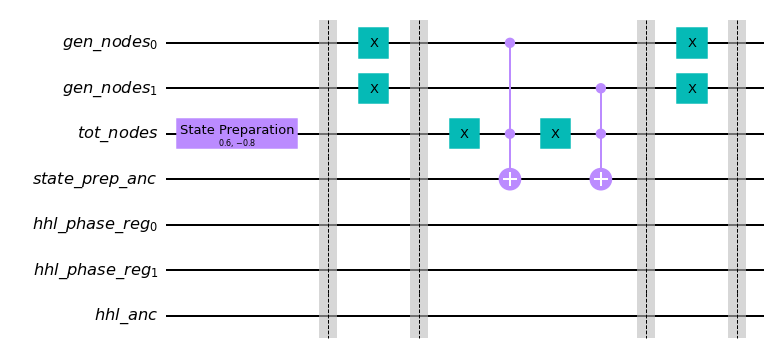

In [14]:


# hhl_circ.h(tot_nodes)
hhl_circ.barrier()
hhl_circ.x(gen_nodes)
hhl_circ.barrier()

for i in range(len(gen_nodes)):
    # Take the i-th entry in tot_nodes' statevector to the last position in the statevector
    for j in range(len(tot_nodes)):
        if i%(2**(j+1))<2**j:
            hhl_circ.x(tot_nodes[j])
    # Last position in tot_nodes' statevector corresponds to the basis state where all qubits in tot_nodes are 1
    # The following statement flips the ancilla when all tot_nodes's qubits are 1 and when gen_nodes[i] is one.
    # The first half of the combined statevector of tot_nodes and state_prep_anc is the exact statevector
    # that we're looking for.
    hhl_circ.mcx([gen_nodes[i]]+list(tot_nodes),state_prep_anc[0])
    # Undo the shuffling we did earlier.
    for j in range(len(tot_nodes)):
        if i%(2**(j+1))<2**j:
            hhl_circ.x(tot_nodes[j])
hhl_circ.barrier()

hhl_circ.x(gen_nodes)
hhl_circ.barrier()
hhl_circ.draw('mpl')


In [15]:
st1 = Statevector.from_instruction(hhl_circ)
print("ST1:")
disp_subsyst_statevector(st1,[0,1])

ST1:
When remaining qubits are in states |00010>,|00011>  (probability= 1.0 ),
the statevector of qubits 0,1 is
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [16]:

# Paulinomial decomposition

H=I
for i in range(len(tot_nodes)-1):
    H=H^I

print("B:\n",B)
print()

H=0*H

paulis=[I,X,Y,Z]

for i in range(4**len(tot_nodes)):
    term=paulis[i%4]
    i=i//4
    for j in range(len(tot_nodes)-1):
        term=term^paulis[i%4]
        i=i//4
    a=sum([((term.to_matrix())@(B))[k][k] for k in range(2**len(tot_nodes))])/(2**len(tot_nodes))
    H+=(a*term)

# Create evolution circuit


# exp_i(A) := exp(-iA)
evolution_op = (-H).exp_i()

trotterized_op = PauliTrotterEvolution(
                trotter_mode='trotter',
                reps=num_time_slices).convert(evolution_op)

trot_exp_H=trotterized_op.to_matrix()

J, P = linalg.eig(trot_exp_H)
print("trot_exp_H : \n" , trot_exp_H)
print("Jb : \n" , J , " \nPb \n" , P)

J=[np.log((el**(-1j)).real) for el in J]
J=[el+2*np.pi*int(el<0) for el in J]
print()
print("Ja : \n" , J , " \nPa \n" , P)

J, P = linalg.eig(B)

print()
print("JB : \n" , J , " \nPB \n" , P)

B:
 [[ 5.23598776 -1.04719755]
 [-1.04719755  5.23598776]]

trot_exp_H : 
 [[ 0.25-0.4330127j -0.75-0.4330127j]
 [-0.75-0.4330127j  0.25-0.4330127j]]
Jb : 
 [ 1. -1.66533454e-16j -0.5-8.66025404e-01j]  
Pb 
 [[ 0.70710678+0.00000000e+00j  0.70710678+0.00000000e+00j]
 [-0.70710678-1.66533454e-16j  0.70710678+1.11022302e-16j]]

Ja : 
 [6.283185307179586, 4.1887902047863905]  
Pa 
 [[ 0.70710678+0.00000000e+00j  0.70710678+0.00000000e+00j]
 [-0.70710678-1.66533454e-16j  0.70710678+1.11022302e-16j]]

JB : 
 [6.28318531+0.j 4.1887902 +0.j]  
PB 
 [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


In [17]:


L=np.array([[int(i==j)*J[i] for j in range(len(J))] for i in range(len(J))])
H_rev_eng = P @ L @ linalg.inv(P)
print("The hamiltonian actually being simulated\nby the approximated evolution operator:\n", H_rev_eng)

The hamiltonian actually being simulated
by the approximated evolution operator:
 [[ 5.23598776+0.j -1.04719755+0.j]
 [-1.04719755+0.j  5.23598776+0.j]]


In [18]:
U=trotterized_op.to_circuit().to_gate()
CU=U.control(2)

# QPE

hhl_circ_temp=QuantumCircuit(gen_nodes,tot_nodes,state_prep_anc,hhl_phase_reg,hhl_anc, name="QPE")
hhl_circ_temp.h(hhl_phase_reg)
hhl_circ_temp.x(state_prep_anc)
repetitions = 1
for counting_qubit in range(len(hhl_phase_reg)):
    for i in range(repetitions):
        # Applying rotation to phase register qubits in reverse order
        # This order will be switched back after applying inverse qft
        hhl_circ_temp.append(CU, [hhl_phase_reg[len(hhl_phase_reg)-1-counting_qubit]]+[state_prep_anc[0]]+[q for q in tot_nodes])
    repetitions *= 2

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits of hhl_phase_reg"""
    # DO forget the Swaps!
    # for qubit in range(n//2):
    #     qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            hhl_circ_temp.cp(-pi/float(2**(j-m)), hhl_phase_reg[m], hhl_phase_reg[j])
        hhl_circ_temp.h(hhl_phase_reg[j])

qft_dagger(len(hhl_phase_reg))

hhl_circ.compose(hhl_circ_temp, inplace=True)
hhl_circ.barrier()

In [19]:
st1 = Statevector.from_instruction(hhl_circ)
print("ST1:")
disp_subsyst_statevector(st1,[4])

ST1:
When remaining qubits are in states |000000>,|000100>  (probability= 0.999999999999999 ),
the statevector of qubits 4 is
[1.+0.j 0.-0.j]


In [20]:

# Conditioned rotations

hhl_circ.compose(construct_asin_x_inv_circuit(len(hhl_phase_reg),4,2,max_eigval/min_eigval), [q for q in hhl_phase_reg]+[hhl_anc[0]], inplace=True)
hhl_circ.barrier()
hhl_circ.x(hhl_anc[0])


Constructing asin(1/(mx)) circuit


In [21]:
st1 = Statevector.from_instruction(hhl_circ)
print("ST1:")
disp_subsyst_statevector(st1,[4])

ST1:
When remaining qubits are in states |000000>,|100000>,|100100>,|000100>  (probability= 0.9999999999999988 ),
the statevector of qubits 4 is
[ 1.+0.j -0.+0.j]


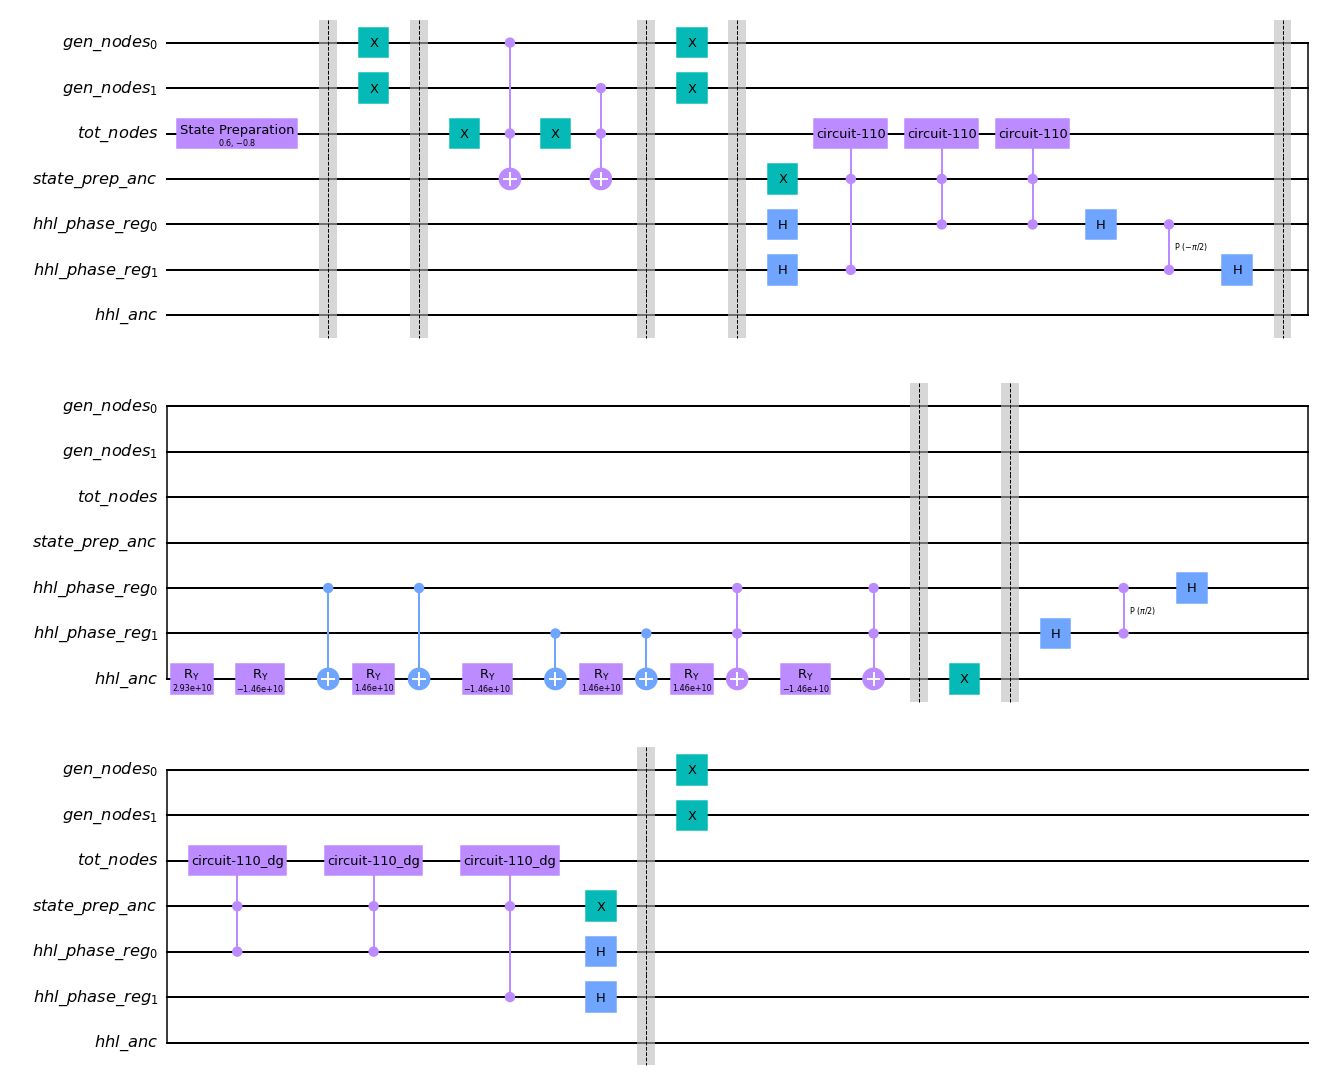

In [22]:

# Uncompute QPE to unentangle the ancillas
hhl_circ.barrier()

hhl_circ.compose(hhl_circ_temp.inverse(), inplace=True)
hhl_circ.barrier()
hhl_circ.x(gen_nodes)
hhl_circ.draw('mpl')

In [23]:
st1 = Statevector.from_instruction(hhl_circ)
print("ST1:")
disp_subsyst_statevector(st1,[4])

ST1:
When remaining qubits are in states |001011>,|101011>,|001111>,|101111>  (probability= 0.999999999999998 ),
the statevector of qubits 4 is
[ 1.+0.j -0.+0.j]


In [24]:

circuit_ID=str(len(os.listdir(circuits_dir)))

circuit_IDs[circuit_key]=circuit_ID

with open("circuit_ID.json", 'w', encoding='utf-8') as f:
    json.dump(circuit_IDs, f, ensure_ascii=False, indent=4)


print("Length of untranspiled HHL", len(hhl_circ))

print("Transpiling HHL circuit for storage")
simulator = Aer.get_backend('aer_simulator')
hhl_circ_transpiled=transpile(hhl_circ, simulator)

with open(os.path.join(circuits_dir,circuit_ID+'.qpy'), 'wb') as fd:
    print("Length of transpiled HHL", len(hhl_circ_transpiled))
    qpy_serialization.dump(hhl_circ_transpiled, fd)

#return(hhl_circ_transpiled)


Length of untranspiled HHL 51
Transpiling HHL circuit for storage
Length of transpiled HHL 304


/tmp/ipykernel_24669/2067201373.py:17: DeprecationWarning: Module 'qiskit.circuit.qpy_serialization' is deprecated since Qiskit Terra 0.23, and will be removed in a future release. Please import from 'qiskit.qpy' instead.
  qpy_serialization.dump(hhl_circ_transpiled, fd)


In [25]:
# # hhl_circ=create_hhl_circ(real_powers=real_powers,B=B,max_eigval=max_eigval,min_eigval=min_eigval,gen_nodes=gen_nodes,tot_nodes=tot_nodes,state_prep_anc=state_prep_anc,hhl_phase_reg=hhl_phase_reg,hhl_anc=hhl_anc)
# # circ.compose(hhl_circ, inplace=True)

# [[0.15445959699125714, []], [-0.013467854613723407, [0]], [-0.025840088768203193, [1]], [-0.04752743575465538, [2]], [-0.08020614044877576, [3]], [-0.1144490102393349, [4]], [0.0021333936021695936, [0, 1]], [0.004041668715259125, [0, 2]], [0.0072178337331401995, [0, 3]], [0.011113216977662375, [0, 4]], [0.007860598761224758, [1, 2]], [0.014004451268689943, [1, 3]], [0.021390965838493186, [1, 4]], [0.026309725848645386, [2, 3]], [0.03946908782564946, [2, 4]], [0.06584440633789866, [3, 4]], [-0.0004406087890895274, [0, 1, 2]], [-0.0008556586582235611, [0, 1, 3]], [-0.0016632728215736365, [0, 1, 4]], [-0.0016895807883750976, [0, 2, 3]], [-0.00330207212677888, [0, 2, 4]], [-0.0065407448950106995, [0, 3, 4]], [-0.003359478950828468, [1, 2, 3]], [-0.006582018596563612, [1, 2, 4]], [-0.01305130239678407, [1, 3, 4]], [-0.02600716412104716, [2, 3, 4]], [3.517106095215182e-05, [0, 1, 2, 3]], [3.9449882891433426e-05, [0, 1, 2, 4]], [5.370024117731954e-05, [0, 1, 3, 4]], [8.599526708462783e-05, [0, 2, 3, 4]], [0.0001526154258253206, [1, 2, 3, 4]], [-3.461015761544577e-05, [0, 1, 2, 3, 4]]]

In [26]:
# Run and get statevector
hhl_circ_transpiled.save_statevector()

result = simulator.run(hhl_circ_transpiled).result()
statevector = result.get_statevector(hhl_circ_transpiled)

#print([statevector[4*i+11] for i in range(2)])

In [27]:
##[0.4534-0.j -0.7123+0.j] 
# classical solution : [0.4583 -0.7083] 

In [28]:
np.asarray(statevector)

array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -1.59081813e-31+3.76719050e-17j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  1.82000380e-31-4.27550696e-17j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  5.62916646e-01-3.09234884e-16j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -7.50555528e-01-4.54656217e-15j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -3.28690244e-18+1.29037306e-32j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -3.28690244e-18+2.50370893e-33j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -2.55140025

In [39]:
J = [np.asarray(statevector)[75].real  , np.asarray(statevector)[79].real ]
J

[0.20766523450333774, -0.2768869793377833]

In [29]:
result.get_counts()

{'0001011': 0.316875150378674,
 '0001111': 0.563333600673199,
 '1001011': 0.043124849621326,
 '1001111': 0.076666399326802}

In [30]:
st1 = Statevector.from_instruction(hhl_circ)
print("ST1:")
disp_subsyst_statevector(st1,[2])

ST1:
When remaining qubits are in states |100111>,|000111>  (probability= 0.999999999999998 ),
the statevector of qubits 2 is
[ 0.6+0.j -0.8-0.j]


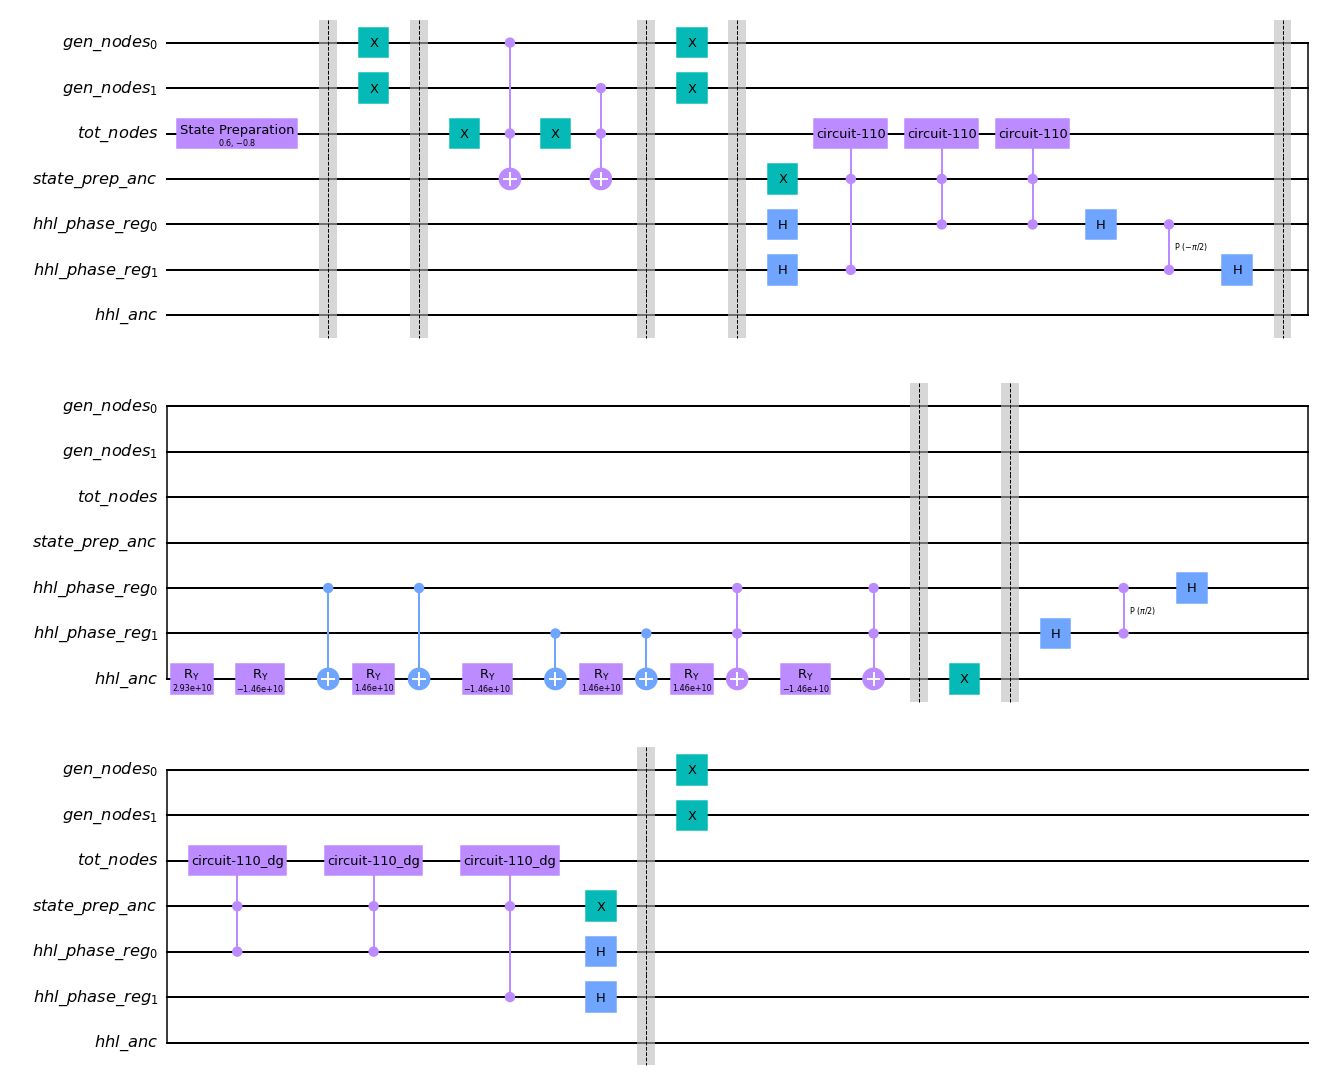

In [31]:
hhl_circ.draw('mpl')